In [1]:

%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)
import jax
from dataclasses import dataclass
import jax.numpy as jnp
import jax.random as jr

import tensorflow_probability.substrates.jax.bijectors as tfb

#with install_import_hook("gpjax", "beartype.beartype"):
import gpjax as gpx
from gpjax.distributions import GaussianDistribution
import matplotlib.pyplot as plt
from matplotlib import rcParams
# plt.style.use(
#     "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
# )
# colors = rcParams["axes.prop_cycle"].by_key()["color"]

key = jr.PRNGKey(123)

import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
from gpjax.kernels.base import AdditiveKernel


import optax as ox
import tensorflow_probability.substrates.jax.bijectors as tfb



from typing import List, Union, Callable
from jaxtyping import Num, Float
from gpjax.typing import Array, ScalarFloat
from beartype.typing import Optional
from gpjax.base import Module, param_field,static_field
import cola
from cola.linalg.decompositions.decompositions import Cholesky
from jax import vmap


# custom bits
from gpjax.precip_gp import VerticalDataset, VerticalSmoother, ConjugatePrecipGP, ProblemInfo, VariationalPrecipGP
from gpjax.normalizer import Normalizer
from gpjax.plotting import plot_data, plot_marginals, plot_interactions, plot_params




# 100_000 entries sampled across time/lat/lon over first day of data

## X2D has:

0"Sea surface temperature (K)"

1"Sensible heat flux (W/m^2)"

2"Latent heat flux (W/m^2)"

3"Vertically-integrated moisture convergence (kg/m^2)"

4"Column relative humidity (%)"


## X3D has:

0"Absolute temperature (K)"

1"Relative humidity (%)"

2"Specific humidity (kg/kg)"

3"Geopotential height (m^2 s^-2)"

4"Zonal wind (m/s)"

5"Meridional wind (m/s)"

6"Potential temperature (K)"

7"Equivalent potential temperature (K)"

8"Equivalent potential temperature saturation deficit (K)"

9"Saturated equivalent potential temperature (K)"

10"MSE-conserving plume buoyancy (m/s^2)"


## static has:

0"Land-sea mask"

1"Angle of sub-gridscale orography (rad)

2"Anisotropy of sub-gridscale orography"

3"Standard deviation of sub-gridscale orography"

4"Slope of sub-gridscale orography"

## Y has:

0"ERA5 Precipitation (mm/hr)"

1"TRMM Precipitation (mm/hr)"

2"TRMM Relative Error (%)"

# plev are
1000.,   2000.,   3000.,   5000.,   7000.,  10000., 15000.,
20000.,  25000.,  30000.,  40000.,  50000.,  60000.,  70000.,80000.,  85000.,  90000.,  92500.,  95000.,  97500., 100000.


In [2]:
# load data
X2d_raw = jnp.array(jnp.load("../data/ERA/NPY_DATA/X2d_sample.npy"), dtype=jnp.float64) # [N, D]
X3d_raw = jnp.array(jnp.load("../data/ERA/NPY_DATA/X3d_sample.npy"), dtype=jnp.float64) # [N, D]
Xstatic_raw = jnp.array(jnp.load("../data/ERA/NPY_DATA/XStatic_sample.npy"), dtype=jnp.float64) # [N, D]
Y_raw = jnp.array(jnp.load("../data/ERA/NPY_DATA/Y_sample.npy"), dtype=jnp.float64) # [N, 1]
# X2d_raw = jnp.array(jnp.load("../data/100_000_one_day/X2D_sample.npy"), dtype=jnp.float64) # [N, D]
# X3d_raw = jnp.array(jnp.load("../data/100_000_one_day/X3D_sample.npy"), dtype=jnp.float64) # [N, D]
# Xstatic_raw = jnp.array(jnp.load("../data/100_000_one_day/XSTATIC_sample.npy"), dtype=jnp.float64) # [N, D]
# Y_raw = jnp.array(jnp.load("../data/100_000_one_day/Y_sample.npy"), dtype=jnp.float64) # [N, 1]





pressure = jnp.array([[1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,60000,70000,80000, 85000,90000,92500,95000,97500,100000]], dtype=jnp.float64)

# random shuffle
X2d = jr.permutation(key, X2d_raw)
X3d = jr.permutation(key, X3d_raw)
Xstatic = jr.permutation(key, Xstatic_raw)
Y = jr.permutation(key, Y_raw)

# look at ERA5 rain
Y = Y[:,0:1]  




# just keep the "prognostic" 3d inputs that joe considered (for now)
# RH, tehta_e^+, theta_e, theta_e^*
names_3d =  ["Absolute temperature,","Relative Humidity", "Specific Humidity", "Geopotential Height", "Zonal Wind","Meridional Wind","Potential Temperature (theta)","Equivalent Potential Temperature (tehta_e)", "Equivalent Potential Temperature Saturation Deficit (theta_e+)", "Saturated Equivalent Potential Temperature (theta_e*)", "MSE-conserving Plume Buoyancy"]
names_3d_short =  ["K,","RH", "q", "gh", "wind_z","wind_m","theta","tehta_e", "theta_e+", "theta_e*", "plume"]
idx_3d = [1,4,5,6,7,8,9]
# idx_3d = [1, 7, 8, 9]
names_3d = [names_3d[i] for i in idx_3d]
names_3d_short = [names_3d_short[i] for i in idx_3d]
X3d = X3d[:,idx_3d,:]


# # also use his "normalisatopm" for sigma_o
sigma_o = jnp.where(Xstatic[:,0]<0.5, 0.0, 1.0+jnp.log(1+Xstatic[:,3])) # optimize threshold?
Xstatic = Xstatic.at[:,3].set(sigma_o)
Xstatic = Xstatic.at[:,0].set(jnp.log(Xstatic[:,0] / (1- Xstatic[:,0])))
names_static = ["Land-sea Mask","Angle of sub-gridscale orography","Anisotropy of sub-gridscale orography","Stdev of sub-gridscale orography","Slope of sub-gridscale orography"]
names_static_short = ["LSM","O_angle","O_anisotrophy","O_sd","O_slope"]
idx_static = [0, 3]
names_static = [names_static[i] for i in idx_static]
names_static_short = [names_static_short[i] for i in idx_static]
Xstatic = Xstatic[:,idx_static]

names_2d = ["Sea Surface temperature", "Sensible heat flux", "Latent heat flux", "Vertically-integrated moisture convergence", "Column relative humidity"]
names_2d_short = ["T_surface","flux_s","flux_l","moisture","CRH"]
idx_2d = [1,2]
names_2d = [names_2d[i] for i in idx_2d]
names_2d_short = [names_2d_short[i] for i in idx_2d]
X2d = X2d[:,idx_2d]



#remove all pressure levels above 500 hPA
lowest_idx =  11 #7
print(f"Removed all pressure levels below {pressure[:,lowest_idx]} hPa")
X3d = X3d[:, :, lowest_idx:]
pressure_levels = pressure[:,lowest_idx:]
pressure_mean = jnp.mean(pressure_levels)
pressure_std = jnp.std(pressure_levels)
pressure_levels = (pressure_levels - pressure_mean) / pressure_std



# remove any entries with nan
X3d_nan_idx = jnp.isnan(X3d).any(axis=1).any(axis=1)
X2d_nan_idx = jnp.isnan(X2d).any(axis=1)
Xstatic_nan_idx = jnp.isnan(Xstatic).any(axis=1)
Y_nan_idx = jnp.isnan(Y).any(axis=1)
any_nan = X3d_nan_idx | X2d_nan_idx | Y_nan_idx | Xstatic_nan_idx
no_nan = ~ any_nan
print(f"Removed {any_nan.sum()} entries with nan")
X2d = X2d[no_nan,:]
X3d = X3d[no_nan,:,:]
Xstatic = Xstatic[no_nan,:]
Y = Y[no_nan,:]


# # remove no rain days
# print(f"Removed {(Y[:,0]==0).sum()} entries with zero rain")
# X3d = X3d[Y[:,0]>0,:]
# X2d = X2d[Y[:,0]>0,:]
# Xstatic = Xstatic[Y[:,0]>0,:]
# Y = Y[Y[:,0]>0,:]



# # also log Y
# print(f"Applied log transform to Y")
# Y = jnp.log(Y-jnp.min(Y)+1e-3)




num_2d_variables= X2d.shape[1]
num_3d_variables= X3d.shape[1]
num_static_variables= Xstatic.shape[1]
num_not_3d_variables = num_2d_variables + num_static_variables
num_variables = num_2d_variables + num_3d_variables + num_static_variables
print(f"using {num_static_variables} static variables")
print(f"using {num_2d_variables} 2d variables")
print(f"using {num_3d_variables} 3d variables")
names = names_3d + names_2d + names_static
names_short = names_3d_short + names_2d_short + names_static_short
print(f"using variables with names {names_short}")


problem_info = ProblemInfo(
    num_2d_variables = num_2d_variables,
    num_3d_variables = num_3d_variables,
    num_static_variables = num_static_variables,
    names_2d_short = names_2d_short,
    names_3d_short = names_3d_short,
    names_static_short = names_static_short,
    names_2d = names_2d,
    names_3d = names_3d,
    names =names,
    names_static = names_static,
    num_variables = num_variables,
    pressure_levels = pressure_levels,
    pressure_mean = pressure_mean,
    pressure_std = pressure_std,
)


    


Removed all pressure levels below [50000.] hPa
Removed 25 entries with nan
using 2 static variables
using 2 2d variables
using 7 3d variables
using variables with names ['RH', 'wind_z', 'wind_m', 'theta', 'tehta_e', 'theta_e+', 'theta_e*', 'flux_s', 'flux_l', 'LSM', 'O_sd']


Standardized X2d and Xstatic with max and min
then standardized X3d with max and min
Standardized X2d and Xstatic as Gaussin
then standardized X3d as Gaussian
no Y standarisation


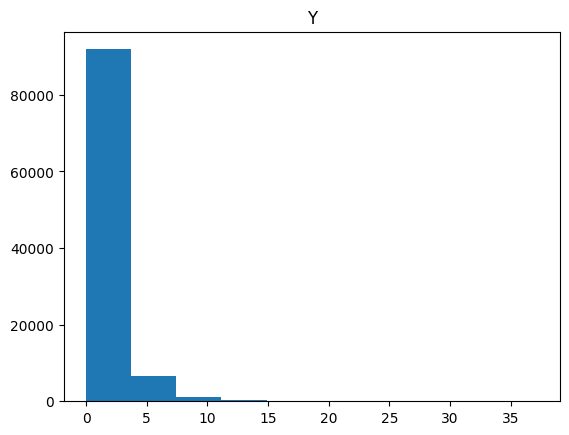

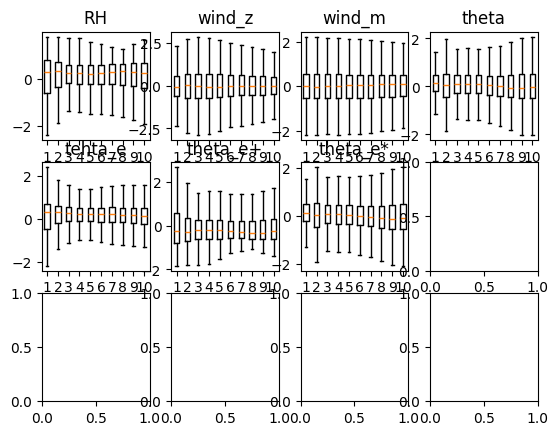

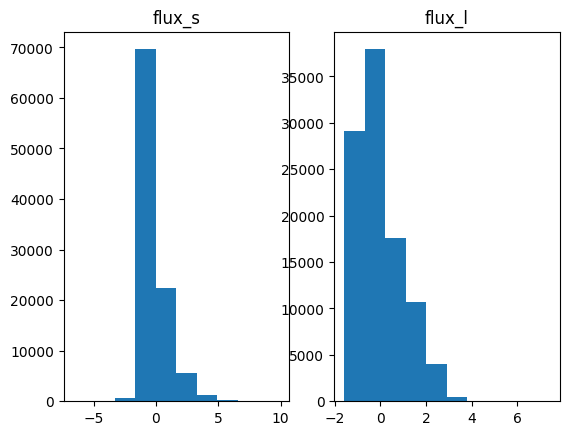

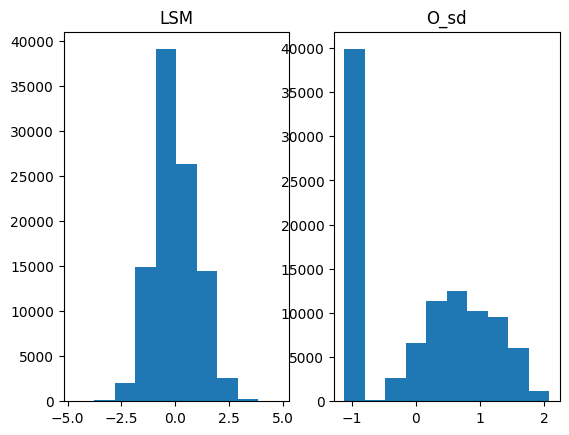

In [3]:

D = VerticalDataset(
    X2d = X2d,
    X3d = X3d,
    Xstatic = Xstatic,
    y=Y,
    standardize=True,
    standardize_with_NF=False,
)

plot_data(problem_info,D)

# plot_marginals(problem_info, D)

In [4]:
def build_log_prior(tau=None) -> callable:

    def log_prior(model):
        log_prob = 0.0

        # if hasattr(model, "smoother"):
        #     smoother_input_scale_prior = tfd.LogNormal(0.0,1.0)
        #     smoother_mean_prior = tfd.Uniform(jnp.min(model.smoother.Z_levels),jnp.max(model.smoother.Z_levels))
        #     log_prob += jnp.sum(smoother_mean_prior.log_prob(model.smoother.smoother_mean))
        #     log_prob += jnp.sum(smoother_input_scale_prior.log_prob(model.smoother.smoother_input_scale))

        lengthscales = jnp.vstack([k.lengthscale for k in model.base_kernels])
        variances = model.interaction_variances
       
        #variance_prior = tfd.Gamma(1.0,0.2)
        #log_prob += jnp.sum(variance_prior.log_prob(variances))

        d = lengthscales.size
        # #l_prior = tfd.LogNormal(jnp.sqrt(2.0) + jnp.log(d)/2.0,jnp.sqrt(1.0))
        # #l_prior = tfd.Gamma(3.0*d,6.0)
        #l_prior = tfd.Gamma(3.0,6.0)
        #log_prob += jnp.sum(l_prior.log_prob(lengthscales))
        l_prior = tfd.HalfCauchy(0.0,tau)
        log_prob += jnp.sum(l_prior.log_prob((1.0 / lengthscales**2)))
            
        #noise_prior = tfd.LogNormal(0.0,10)
        #log_prob += noise_prior.log_prob(model.likelihood.obs_stddev)

        return log_prob
    
    return log_prior



def init_smoother():
    smoother_input_scale_bijector = tfb.Softplus(low=jnp.array(1e-1, dtype=jnp.float64))
    smoother_mean_bijector =  tfb.SoftClip(low=jnp.min(pressure_levels+1e-3), high=jnp.max(pressure_levels-1e-3))
    smoother = VerticalSmoother(
        jnp.array([[0.0]*num_3d_variables]), 
        jnp.array([[1.0]*num_3d_variables]), 
        Z_levels=pressure_levels
        ).replace_bijector(smoother_input_scale=smoother_input_scale_bijector,smoother_mean=smoother_mean_bijector)
    return smoother


def init_kernels(data):
    lengthscale_bij = tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(1e2, dtype=jnp.float64))
    return  [gpx.kernels.RBF(lengthscale=jnp.array([1.0]), active_dims=[i]).replace_trainable(variance=False).replace_bijector(lengthscale = lengthscale_bij) for i in range(data.dim)]

def init_likelihood(data, obs_stddev = jnp.array(1.0, dtype=jnp.float64) ):
    obs_bij=tfb.Softplus(low=jnp.array(1e-3, dtype=jnp.float64))
    return gpx.likelihoods.Gaussian(num_datapoints=data.n, obs_stddev=obs_stddev).replace_bijector(obs_stddev=obs_bij)




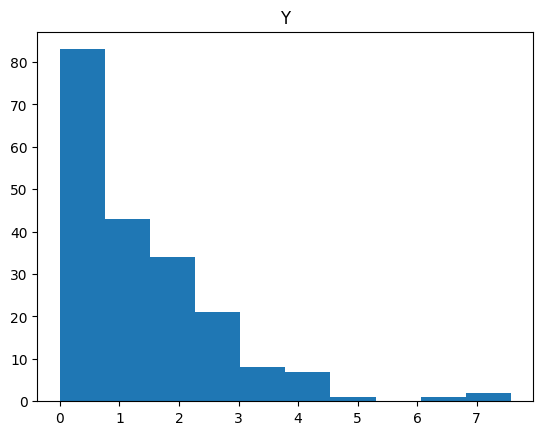

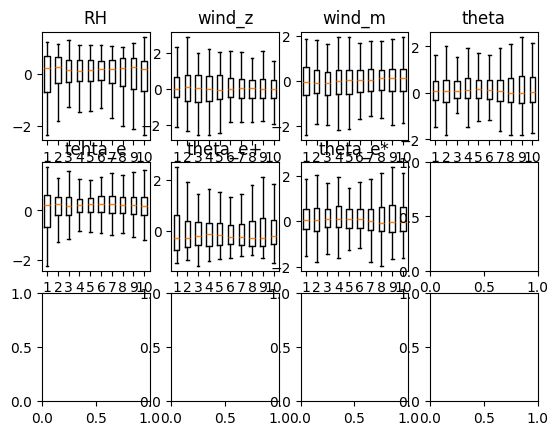

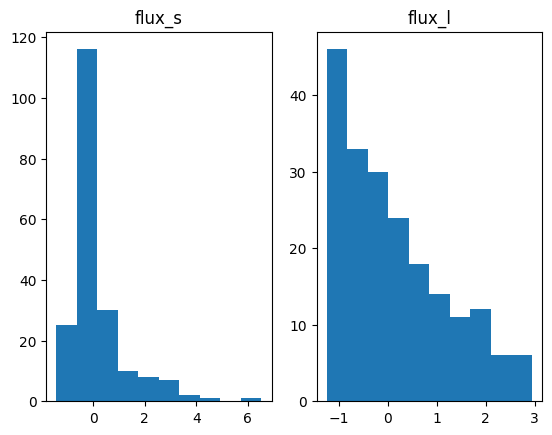

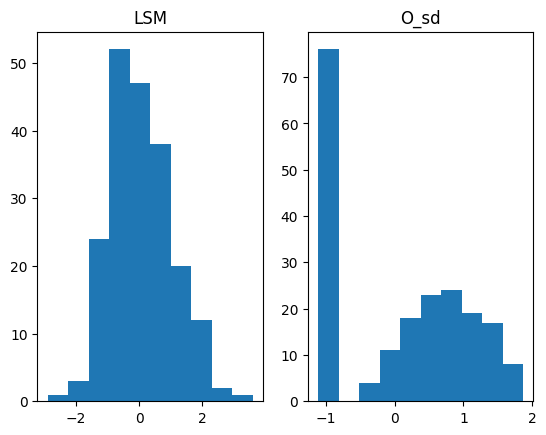

In [5]:
# prep fancy kernel for model
# first fit with small data to get init for SVGP
num_data_for_init=200
D_small = D.get_subset(num_data_for_init, space_filling=False,use_output=True)

plot_data(problem_info, D_small)

  0%|          | 0/200 [00:00<?, ?it/s]

Equivalent Potential Temperature (tehta_e) and Relative Humidity have correlation 0.7684932956613358
Equivalent Potential Temperature Saturation Deficit (theta_e+) and Relative Humidity have correlation -0.9559655842734697
Saturated Equivalent Potential Temperature (theta_e*) and Potential Temperature (theta) have correlation 0.9859636842466943
noise is 1.0225789850273614
interaction vars [1.79217778 0.97195705 0.02431361]


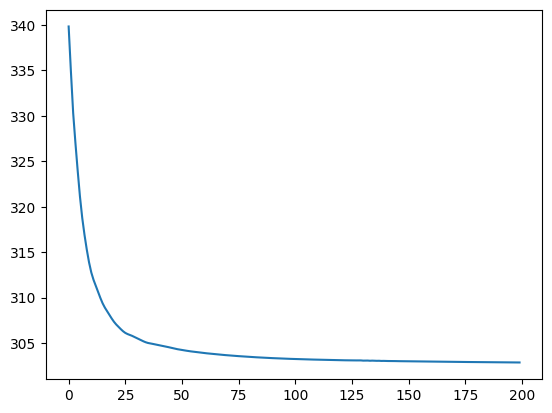

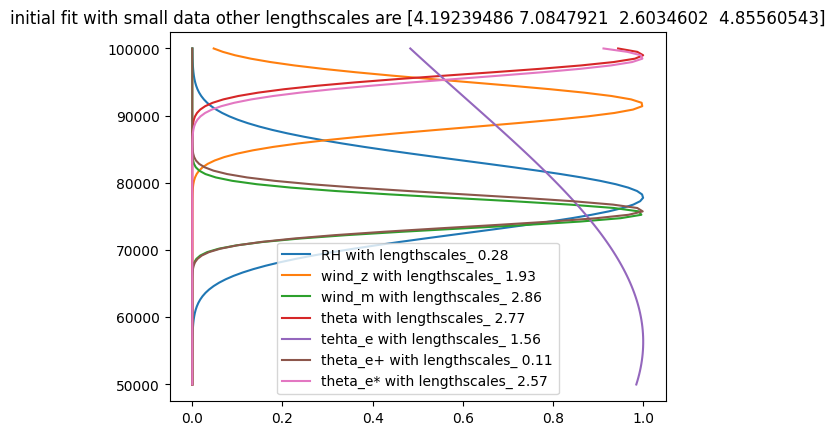

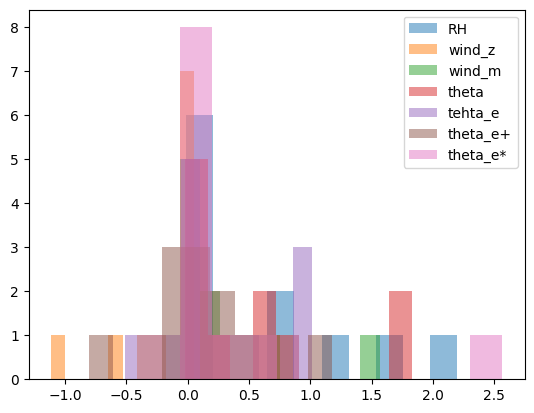

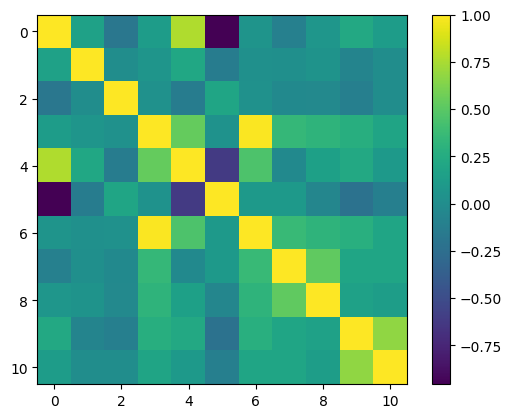

<Figure size 640x480 with 0 Axes>

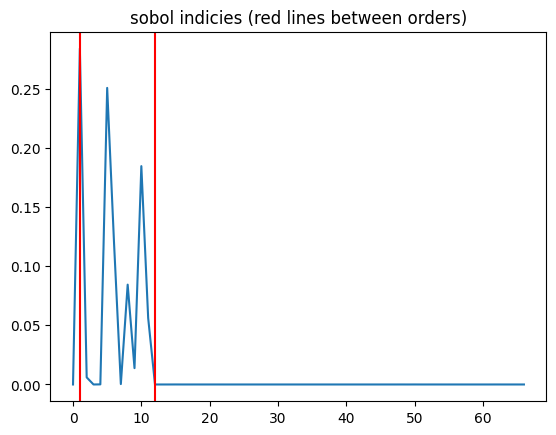

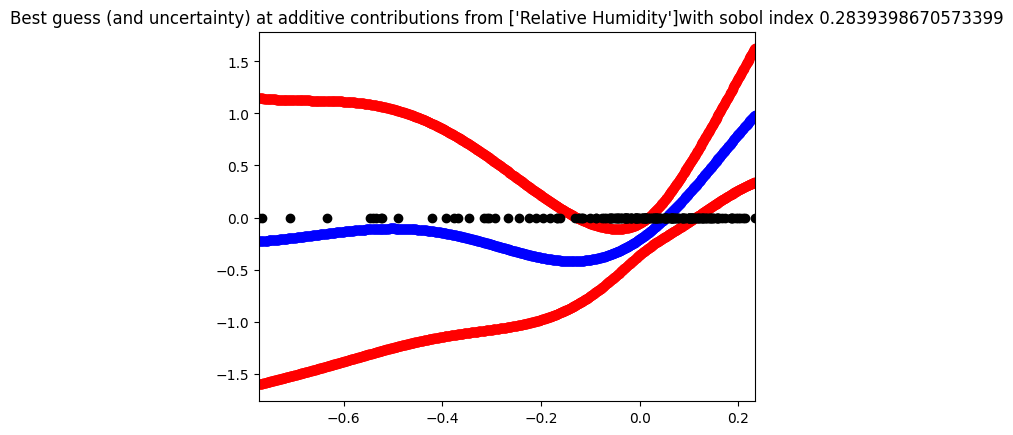

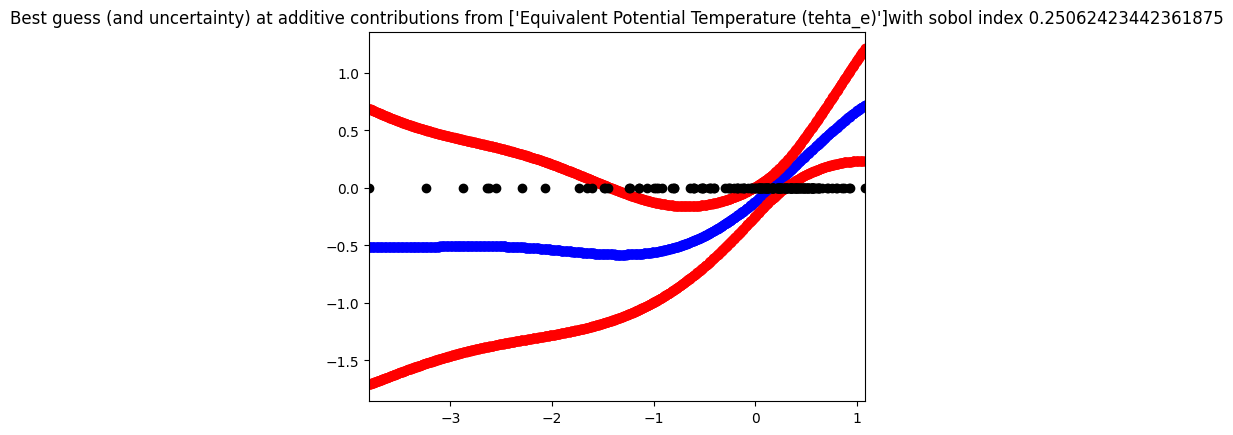

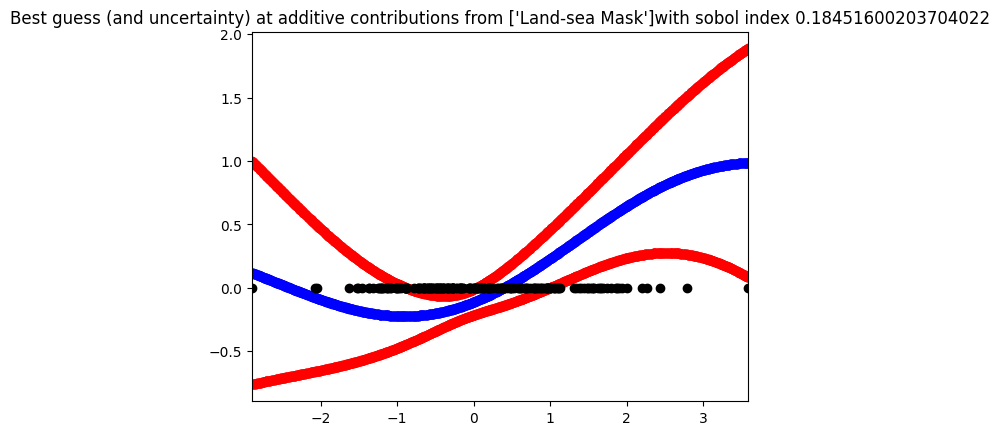

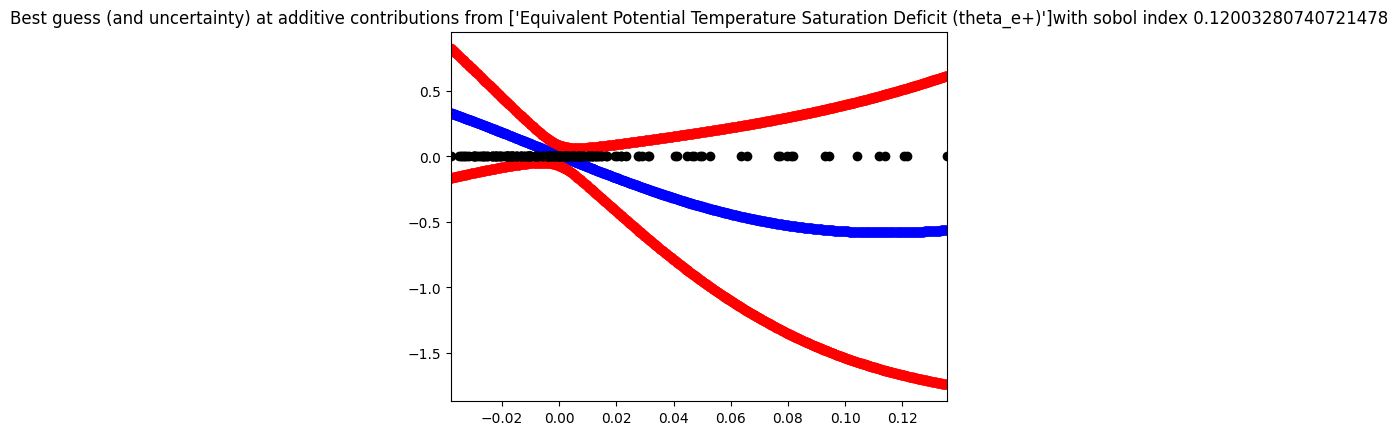

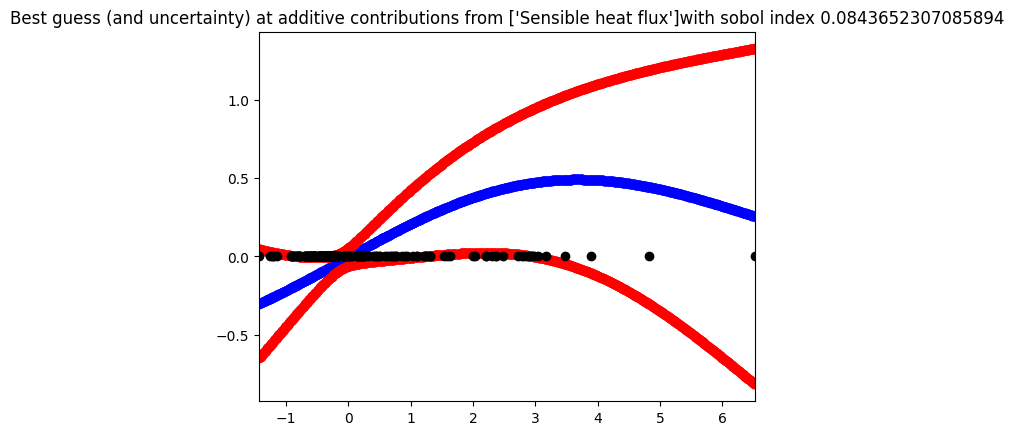

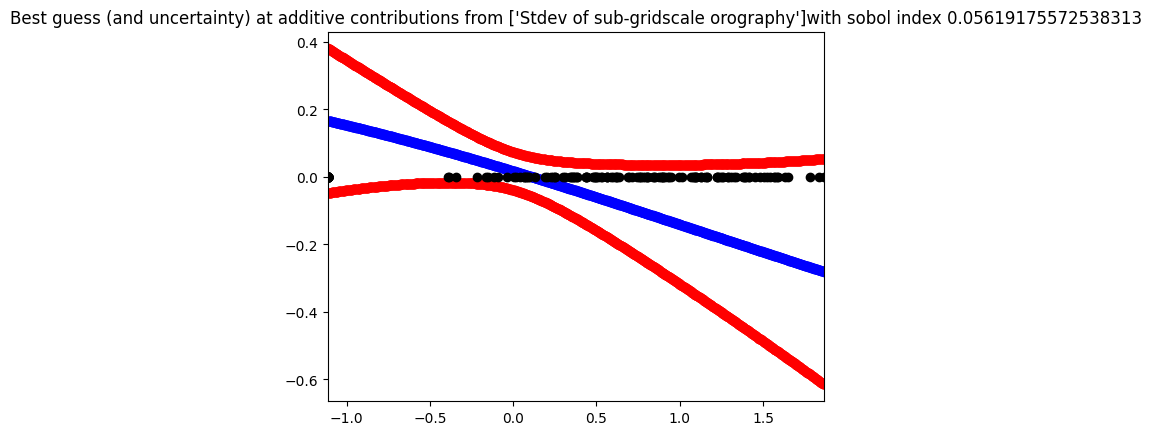

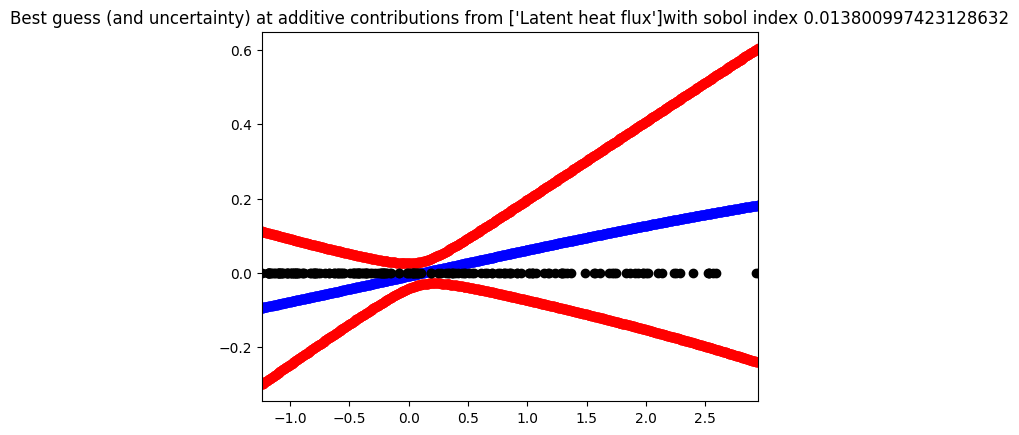

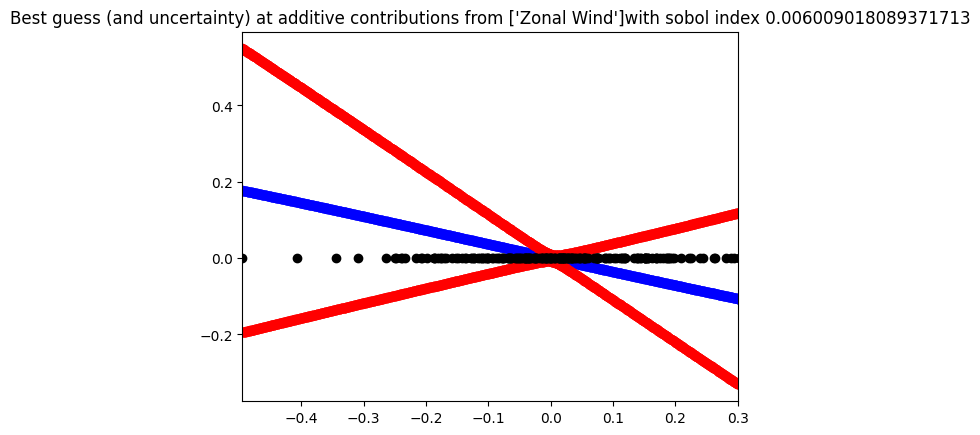

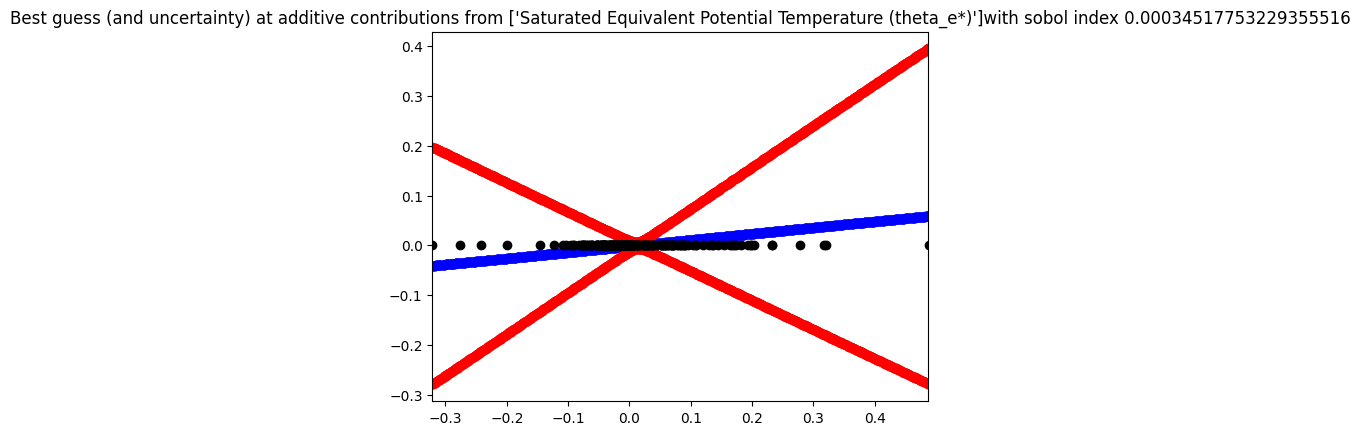

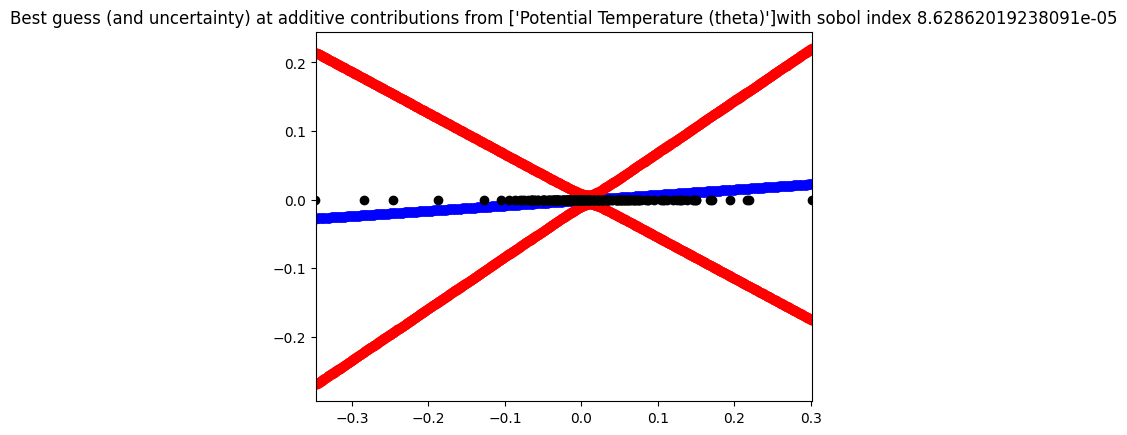

In [6]:
# fit with small data
starting_var = jnp.var(D_small.y)
posterior = ConjugatePrecipGP(
    base_kernels=init_kernels(D_small), 
    likelihood=init_likelihood(D_small, obs_stddev = jnp.array(1.0, dtype=jnp.float64) ),
    smoother=init_smoother(),
    max_interaction_depth=2,
    interaction_variances=jnp.array([starting_var/3.0]*3, dtype=jnp.float64),
    jitter=jnp.array(1e-5, dtype=jnp.float64),
    measure="empirical",
    second_order_empirical=False,
    )
plt.figure()
# opt_posterior, history = gpx.fit_scipy(
#         model=posterior,
#         objective=jax.jit(posterior.loss_fn(negative=True, log_prior=None, use_loocv=True)),#build_log_prior(tau=1.0))),
#         train_data=D_small,
#         safe=False,
#     )

opt_posterior, history = gpx.fit(
        model=posterior,
        objective=jax.jit(posterior.loss_fn(negative=True, log_prior=None)),
        train_data=D_small,
        optim=ox.adam(1e-1),
        num_iters=200,
        safe=False,
        key=key,
    )





plt.plot(history)
plot_params(problem_info, opt_posterior,D_small, title="initial fit with small data", print_corr=True)
print(f"noise is {opt_posterior.likelihood.obs_stddev}")
print(f"interaction vars {opt_posterior.interaction_variances}")
plot_interactions(problem_info, opt_posterior, D_small, k=10, use_range=False)


  0%|          | 0/500 [00:00<?, ?it/s]

Equivalent Potential Temperature (tehta_e) and Relative Humidity have correlation 0.7971554603899238
Equivalent Potential Temperature Saturation Deficit (theta_e+) and Relative Humidity have correlation -0.9619987365220036
Saturated Equivalent Potential Temperature (theta_e*) and Potential Temperature (theta) have correlation 0.9860222730996201
interaction vars [1.19275515 0.10571028 0.11828688]


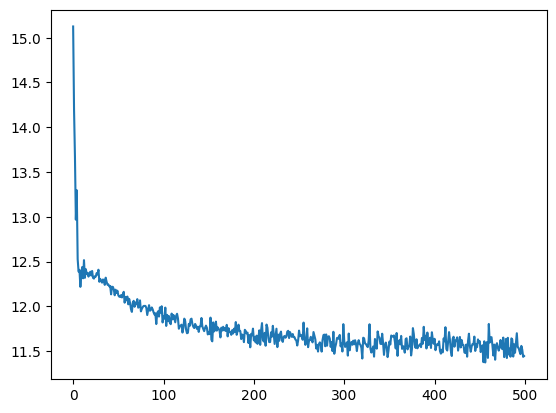

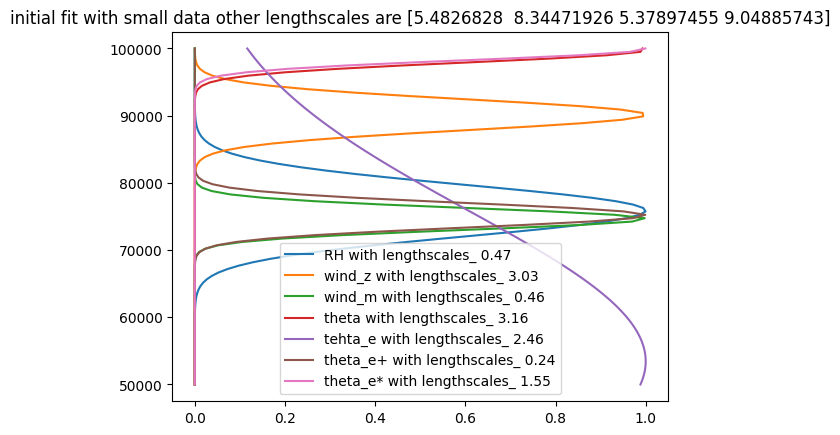

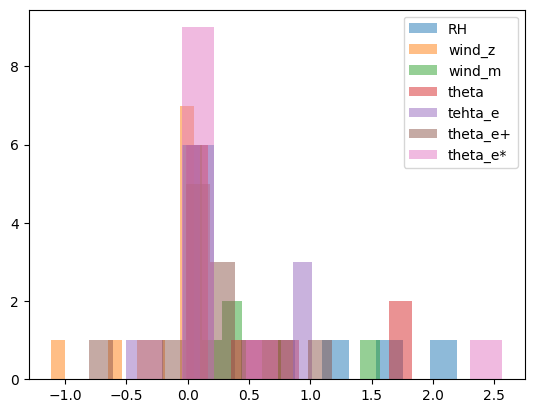

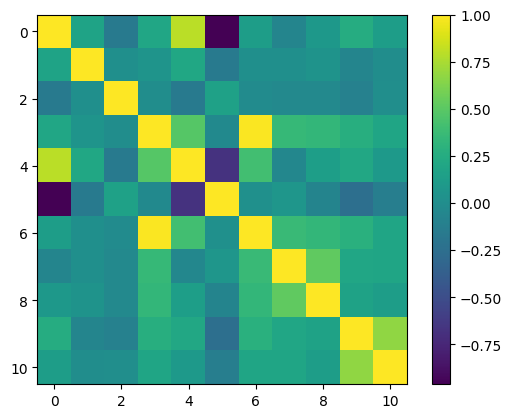

<Figure size 640x480 with 0 Axes>

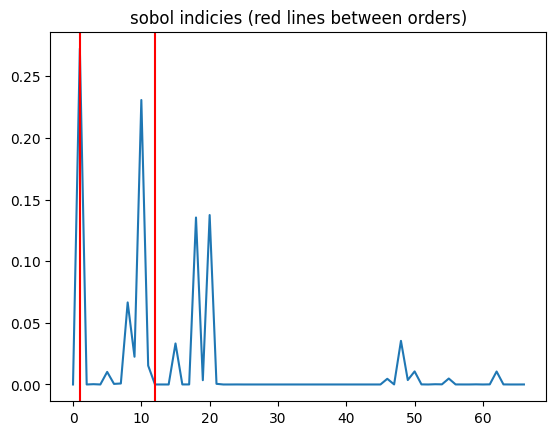

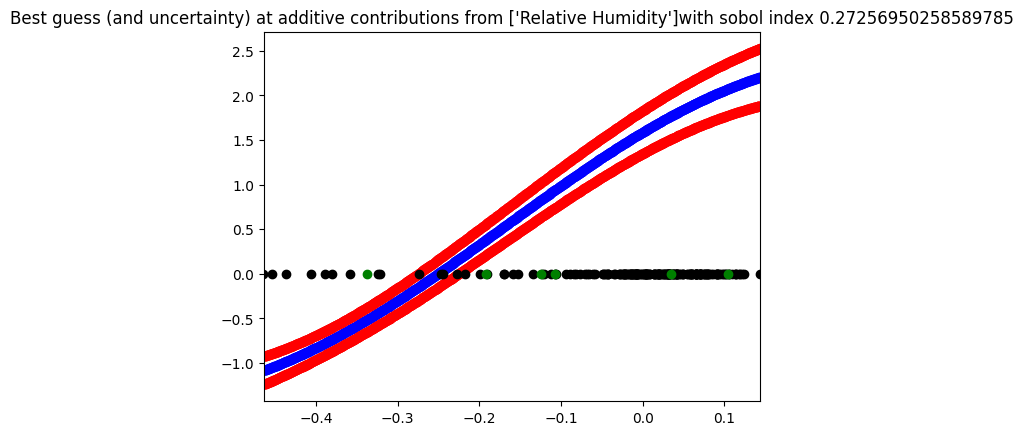

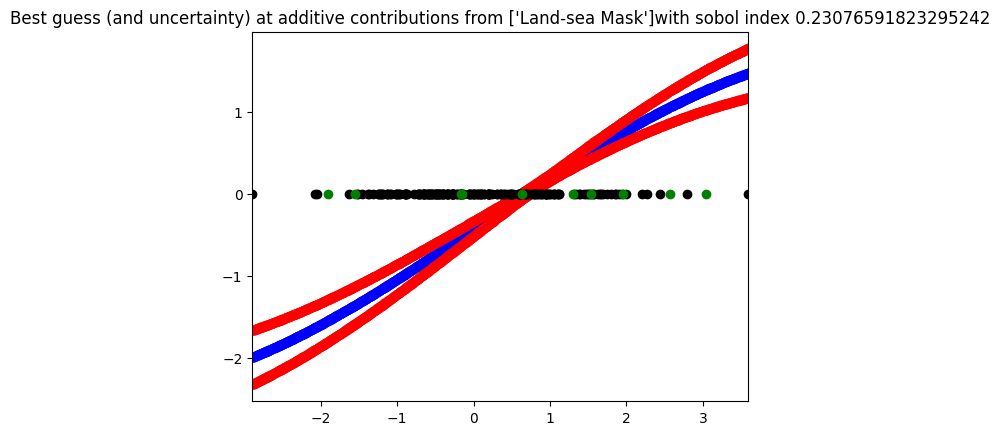

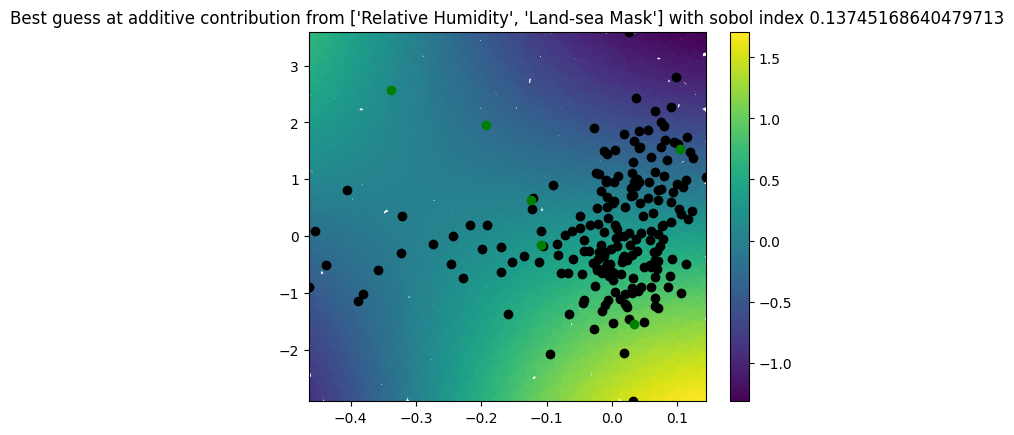

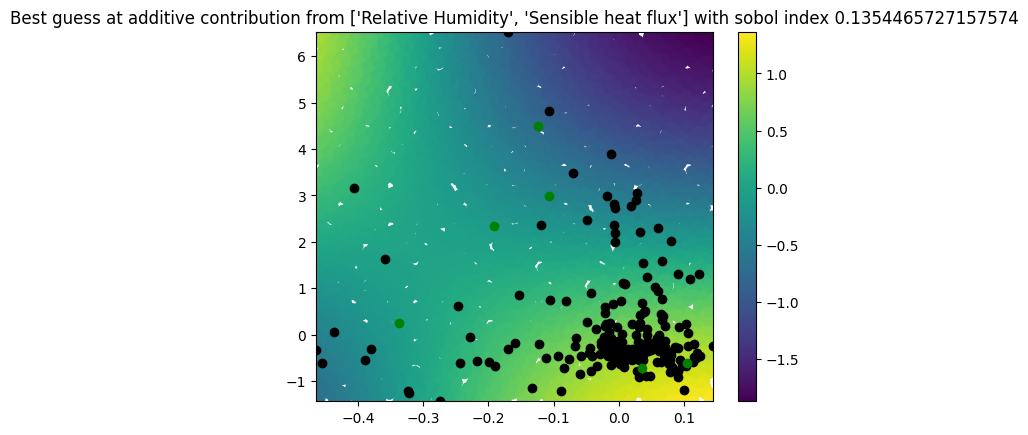

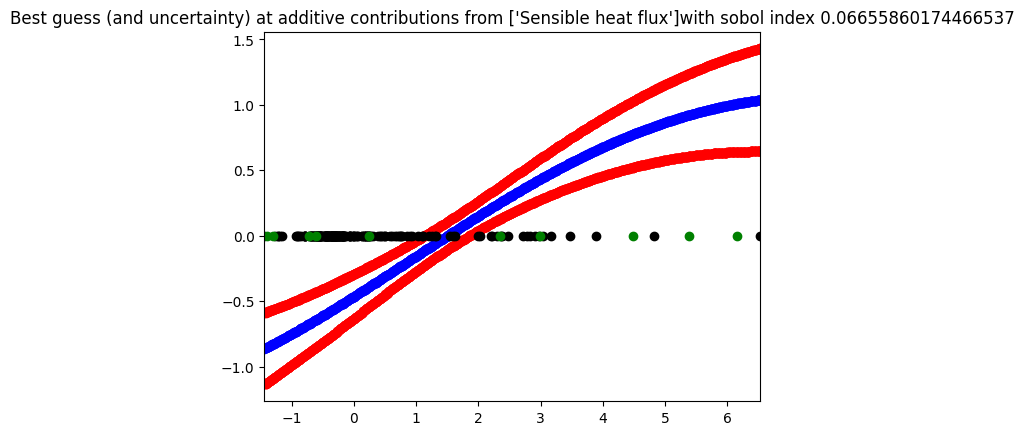

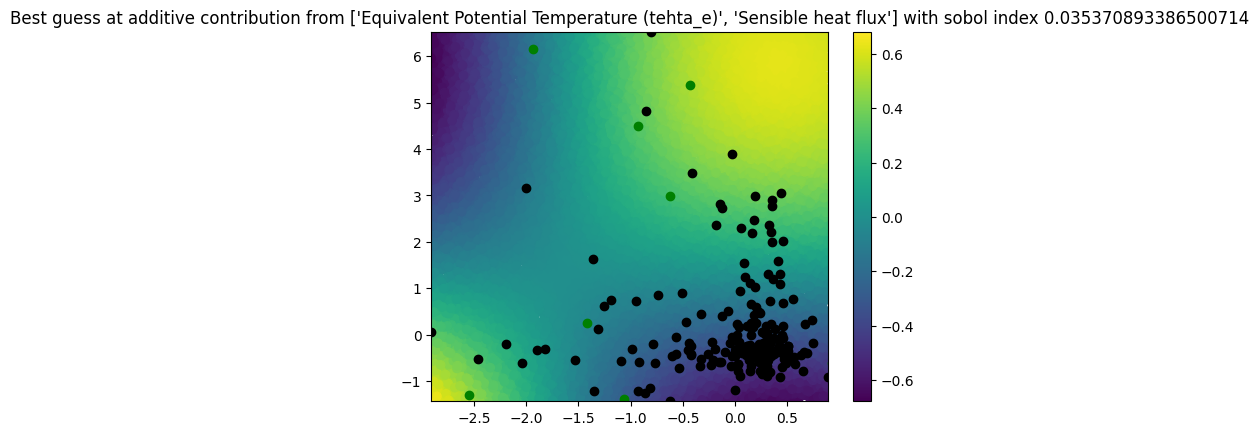

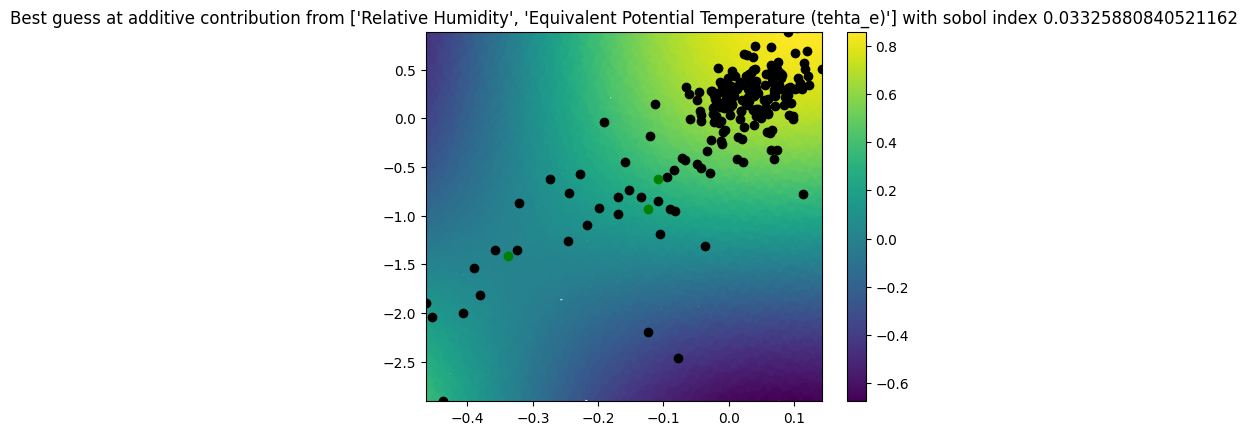

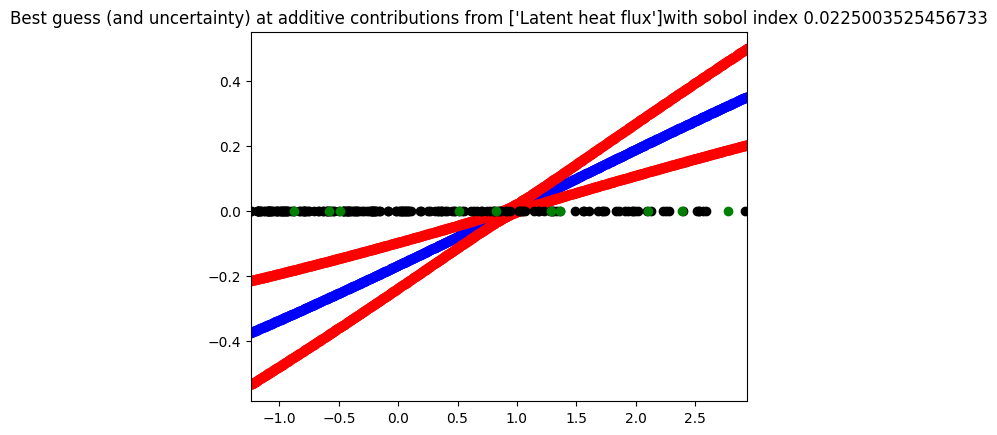

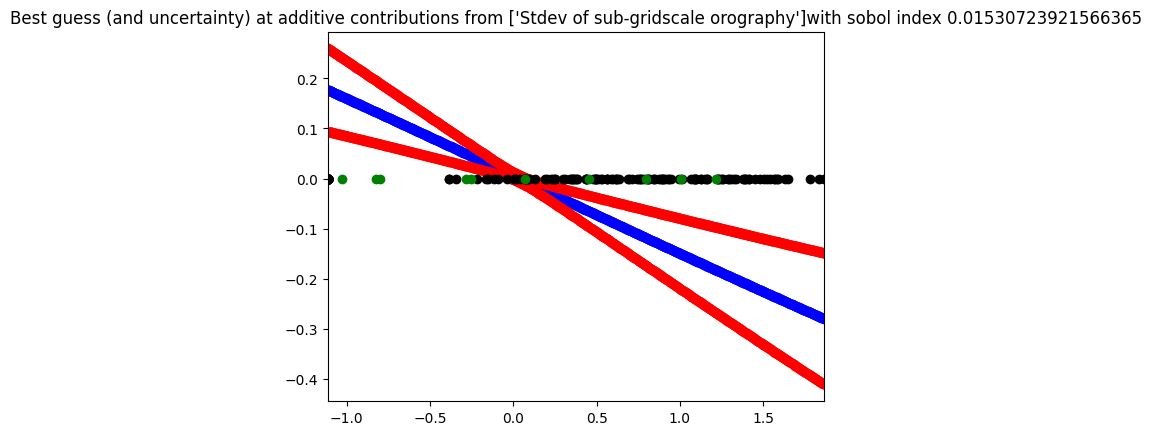

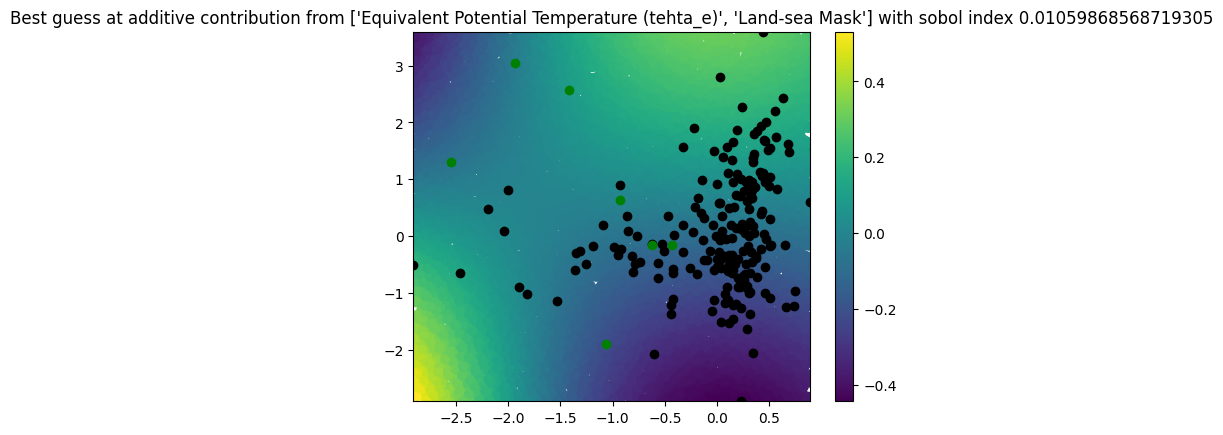

In [8]:

starting_var = jnp.var(D.y)
likelihood = gpx.likelihoods.Exponential(num_datapoints=D.n)
assert jnp.min(D.y) >= 0


num_inducing=10
smoothed = opt_posterior.smoother.smooth_data(D_small)[0]
inducing_inputs = jr.uniform(key, (num_inducing, D_small.dim), minval=jnp.min(smoothed, axis=0), maxval=jnp.max(smoothed, axis=0))
#variational_mean = jnp.zeros((num_inducing, 1))
variational_mean = opt_posterior.predict(inducing_inputs, D_small).mean()[:,None]
if isinstance(likelihood, gpx.likelihoods.Exponential):
    variational_mean = jnp.log(jnp.maximum(variational_mean,1e-5))
variational_root_covariance = jnp.eye(num_inducing)



variational_posterior = VariationalPrecipGP(
    base_kernels=opt_posterior.base_kernels, 
    likelihood=likelihood,
    smoother=opt_posterior.smoother,
    max_interaction_depth=opt_posterior.max_interaction_depth,
    interaction_variances=jnp.array([starting_var/(opt_posterior.max_interaction_depth+1.0)]*(opt_posterior.max_interaction_depth+1), dtype=jnp.float64),
    jitter=jnp.array(1e-5, dtype=jnp.float64),
    measure=opt_posterior.measure,
    second_order_empirical=opt_posterior.second_order_empirical,
    inducing_inputs=inducing_inputs,
    variational_mean=variational_mean,
    variational_root_covariance=variational_root_covariance,
    )
plt.figure()

variational_posterior = variational_posterior.replace_trainable(inducing_inputs=False)

opt_variational_posterior, history = gpx.fit(
        model=variational_posterior,
        objective=variational_posterior.loss_fn(negative=True, log_prior=None), #todo rejit
        train_data=D,
        optim=ox.adam(1e-1),
        num_iters=500,
        batch_size=500,
        safe=False,
        key=key,
    )


plt.plot(jnp.log(history))
plot_params(problem_info, opt_variational_posterior,D_small, title="initial fit with small data", print_corr=True)
try:
    print(f"noise is {opt_variational_posterior.likelihood.obs_stddev}")
except:
    pass
print(f"interaction vars {opt_variational_posterior.interaction_variances}")
plot_interactions(problem_info, opt_variational_posterior, D_small, k=10, use_range=False)
